### Import libraries

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from functools import reduce
from datetime import datetime, timedelta
import pytz
import json
%matplotlib inline

### Data provided
1) Several CSV files containing timeseries :
  * different power generation technologies
  * power demand
  * spot price of electricity 
2) JSON file to map timeseries ids to what they represent

In [10]:
# create function to load JSON files as dictionaries

def load_json(json_filename):
    with open(json_filename, encoding="utf8") as f:
        dict_from_json = json.loads(f.read())
    return dict_from_json

dict_energy = load_json("dict_energy.json")

dict_energy

{'600': 'spot_price',
 '10010': 'wind',
 '10027': 'power_demand',
 '79': 'gas',
 '10008': 'coal',
 '74': 'nuclear',
 '10063': 'hydro',
 '84': 'solar'}

In [23]:
# get a list of the CSV files

files_list = os.listdir()
csv_files = filter(lambda x: ".csv" in x, files_list)

csv_files

In [24]:
# in order to see what's inside the filtered object we can use list()

list_csv = list(csv_files)

In [25]:
list_csv

['demand.csv',
 'nuclear.csv',
 'gas.csv',
 'solar.csv',
 'hydro.csv',
 'coal.csv',
 'wind.csv',
 'spot_price.csv']

In [26]:
# get dataframes out of each csv file and append it to a list
list_df = [pd.read_csv(file) for file in list_csv]

# merge all the dataframes together
how = "outer"
energy = reduce(
    lambda left, right: pd.merge(left, right, on="datetime", how=how),
    list_df
)

energy.head()

datetime  ind_10027  ind_74  ind_79  ind_84  \
0  2019-01-01T00:00:00.000+01:00    23251.2  6059.2  2954.0     7.1   
1  2019-01-01T01:00:00.000+01:00    22485.0  6059.2  3044.1     8.0   
2  2019-01-01T02:00:00.000+01:00    20977.0  6059.2  3138.6     7.5   
3  2019-01-01T03:00:00.000+01:00    19754.2  6059.2  3596.2     7.5   
4  2019-01-01T04:00:00.000+01:00    19320.6  6063.4  3192.6     7.5   

   ind_10063  ind_10008  ind_10010  ind_600  
0     3202.8     1867.0     3830.3    66.88  
1     2884.4     1618.0     3172.1    66.88  
2     1950.8     1535.3     2980.5    66.00  
3     1675.7     1344.0     2840.0    63.64  
4     1581.8     1345.0     3253.4    58.85

### Data analysis!!

In [27]:
# convert the names of the columns

# from ind_XXXX to a better name for the series. Using the dict_energy dictionary created before

new_columns = []

for col in energy.columns:
    for key, value in dict_energy.items():
        if key in col:
            new_columns.append(value)
            
energy.columns = ["datetime"] + new_columns

energy.tail()

datetime  power_demand  nuclear     gas  solar  \
8732  2019-12-30T20:00:00.000+01:00       31160.6   7106.3  4400.0    0.1   
8733  2019-12-30T21:00:00.000+01:00       31152.9   7106.3  4832.3    NaN   
8734  2019-12-30T22:00:00.000+01:00       29151.0   7105.3  4467.0    NaN   
8735  2019-12-30T23:00:00.000+01:00       26989.6   7107.2  4672.2    NaN   
8736  2019-12-31T00:00:00.000+01:00       24350.5   7099.0  3765.9    NaN   

       hydro   coal    wind  spot_price  
8732  7910.8  685.0  2013.5       47.50  
8733  7517.6  681.0  2096.7       46.42  
8734  7080.2  698.0  2028.3       42.76  
8735  6716.1  626.0  2031.8       40.88  
8736  6403.5  528.0  1927.2       37.55

In [ ]:
# preprocessing datetime column

# slicing the timezone info from the string and keeping the UTC date
# energy["datetime"] = energy["datetime"].map(lambda x: x[:-6])

In [32]:
# Feature engineering: time related variables

# convert string dates into datetime objects
energy["datetime"] = pd.to_datetime(energy["datetime"], utc=True)
        
energy.head()

datetime  power_demand  nuclear     gas  solar   hydro  \
0 2018-12-31 23:00:00+00:00       23251.2   6059.2  2954.0    7.1  3202.8   
1 2019-01-01 00:00:00+00:00       22485.0   6059.2  3044.1    8.0  2884.4   
2 2019-01-01 01:00:00+00:00       20977.0   6059.2  3138.6    7.5  1950.8   
3 2019-01-01 02:00:00+00:00       19754.2   6059.2  3596.2    7.5  1675.7   
4 2019-01-01 03:00:00+00:00       19320.6   6063.4  3192.6    7.5  1581.8   

     coal    wind  spot_price  year        date  month  day  hour  weekday  \
0  1867.0  3830.3       66.88  2018  2018-12-31     12   31    23        0   
1  1618.0  3172.1       66.88  2019  2019-01-01      1    1     0        1   
2  1535.3  2980.5       66.00  2019  2019-01-01      1    1     1        1   
3  1344.0  2840.0       63.64  2019  2019-01-01      1    1     2        1   
4  1345.0  3253.4       58.85  2019  2019-01-01      1    1     3        1   

   weekend  
0        0  
1        0  
2        0  
3        0  
4        0

In [33]:
energy["datetime"].values[0]

numpy.datetime64('2018-12-31T23:00:00.000000000')

In [34]:
# Create date, year, month, day, weekday, weekend, hour features

energy["year"] = energy["datetime"].dt.year
energy["date"] = energy["datetime"].dt.date
energy["month"] = energy["datetime"].dt.month
energy["day"] = energy["datetime"].dt.day
energy["hour"] = energy["datetime"].dt.hour
energy["weekday"] = energy["datetime"].dt.weekday
energy["weekend"] = energy["weekday"].map(lambda x: 1*(x>4))

In [35]:
energy.head()

datetime  power_demand  nuclear     gas  solar   hydro  \
0 2018-12-31 23:00:00+00:00       23251.2   6059.2  2954.0    7.1  3202.8   
1 2019-01-01 00:00:00+00:00       22485.0   6059.2  3044.1    8.0  2884.4   
2 2019-01-01 01:00:00+00:00       20977.0   6059.2  3138.6    7.5  1950.8   
3 2019-01-01 02:00:00+00:00       19754.2   6059.2  3596.2    7.5  1675.7   
4 2019-01-01 03:00:00+00:00       19320.6   6063.4  3192.6    7.5  1581.8   

     coal    wind  spot_price  year        date  month  day  hour  weekday  \
0  1867.0  3830.3       66.88  2018  2018-12-31     12   31    23        0   
1  1618.0  3172.1       66.88  2019  2019-01-01      1    1     0        1   
2  1535.3  2980.5       66.00  2019  2019-01-01      1    1     1        1   
3  1344.0  2840.0       63.64  2019  2019-01-01      1    1     2        1   
4  1345.0  3253.4       58.85  2019  2019-01-01      1    1     3        1   

   weekend  
0        0  
1        0  
2        0  
3        0  
4        0

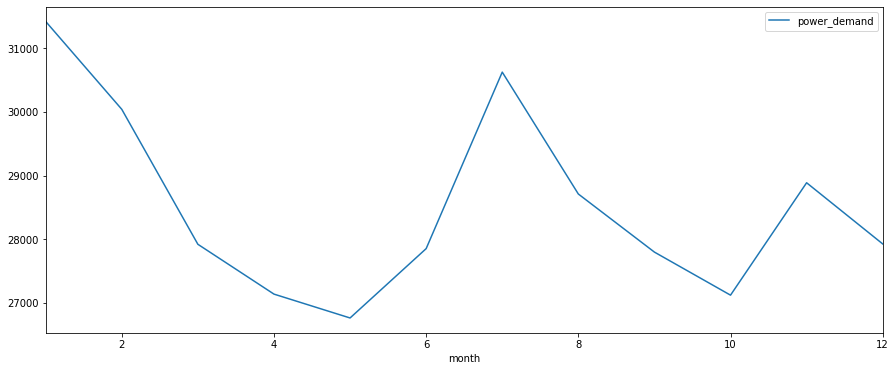

In [36]:
# return the average monthly values for power demand

energy.groupby("month").mean()[["power_demand"]].plot(figsize=(15, 6))

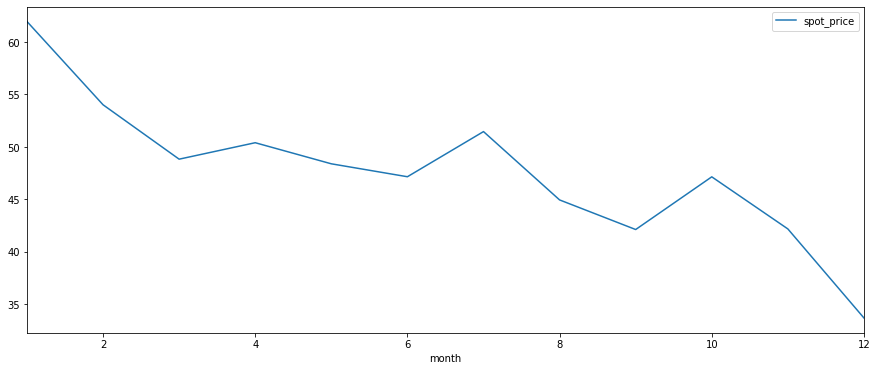

In [37]:
# return the average monthly spot_price

energy.groupby("month").mean()[["spot_price"]].plot(figsize=(15, 6))

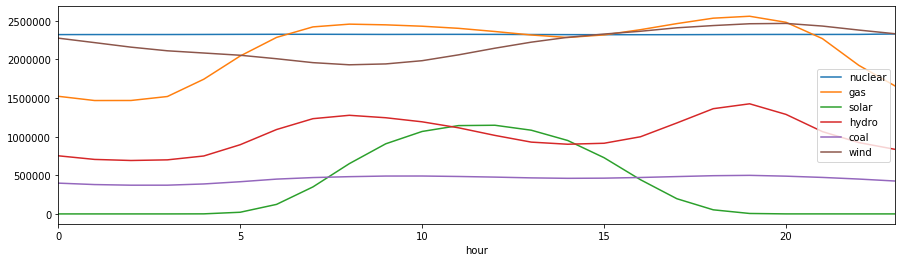

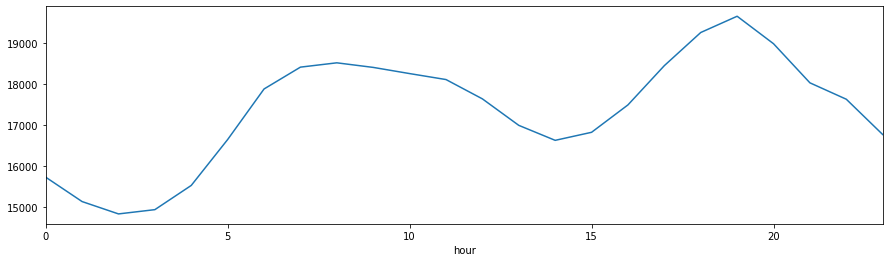

In [38]:
# create a list including all the features related to power generation:
# nuclear, gas, solar, hydro, coal, wind

power_gen = ["nuclear", "gas", "solar", "hydro", "coal", "wind"]

# calculate hourly total production for each type of generation
energy.groupby("hour").sum()[power_gen].plot(figsize=(15, 4))
plt.show()

# calculate hourly average price for energy
energy.groupby("hour").sum()["spot_price"].plot(figsize=(15, 4))

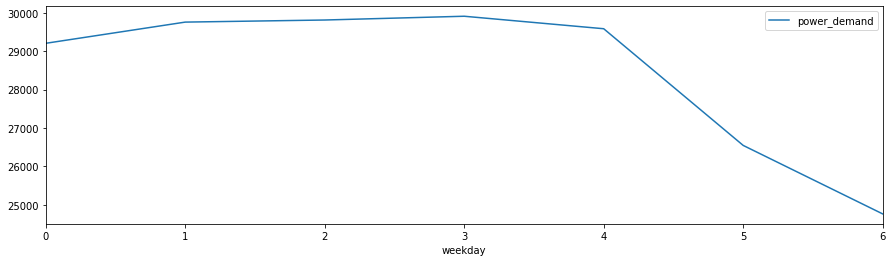

In [39]:
# weekday average value of power_demand

energy.groupby("weekday").mean()[["power_demand"]].plot(figsize=(15, 4))

In [40]:
# create a new column containing the power demand that is covered by green energy sources

# considering wind and solar as green energy

energy["green_covered_demand"] = \
(energy["wind"] + energy["solar"]) / energy["power_demand"]

In [41]:
energy.tail()

datetime  power_demand  nuclear     gas  solar   hydro  \
8732 2019-12-30 19:00:00+00:00       31160.6   7106.3  4400.0    0.1  7910.8   
8733 2019-12-30 20:00:00+00:00       31152.9   7106.3  4832.3    NaN  7517.6   
8734 2019-12-30 21:00:00+00:00       29151.0   7105.3  4467.0    NaN  7080.2   
8735 2019-12-30 22:00:00+00:00       26989.6   7107.2  4672.2    NaN  6716.1   
8736 2019-12-30 23:00:00+00:00       24350.5   7099.0  3765.9    NaN  6403.5   

       coal    wind  spot_price  year        date  month  day  hour  weekday  \
8732  685.0  2013.5       47.50  2019  2019-12-30     12   30    19        0   
8733  681.0  2096.7       46.42  2019  2019-12-30     12   30    20        0   
8734  698.0  2028.3       42.76  2019  2019-12-30     12   30    21        0   
8735  626.0  2031.8       40.88  2019  2019-12-30     12   30    22        0   
8736  528.0  1927.2       37.55  2019  2019-12-30     12   30    23        0   

      weekend  green_covered_demand  
8732        0               0.06462  
8733        0                   NaN  
8734        0                   NaN  
8735        0                   NaN  
8736        0                   NaN

In [42]:
# day of the period in which more demand was covered by green energy
# and what percentage was covered

id_max_green = energy["green_covered_demand"].idxmax()
id_max_green
max_green_date = energy.loc[id_max_green, "date"]
max_green_pct = energy.loc[id_max_green, "green_covered_demand"]

print(f"{np.round(max_green_pct * 100, 1)} % of demand covered by green energy on {max_green_date}")

78.3 % of demand covered by green energy on 2019-11-03


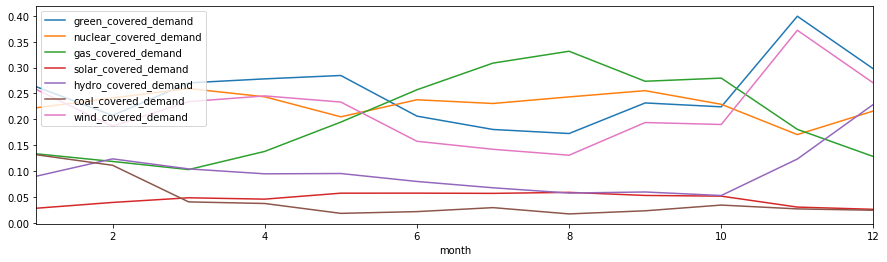

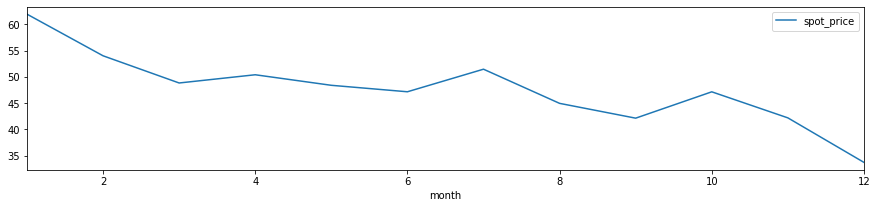

In [43]:
# average monthly demand covered by each type of generation

# first create the coverage columns
for pp in power_gen:
    energy[f"{pp}_covered_demand"] = energy[pp] / energy["power_demand"]
    
# get list of coverage per technology
pp_covered = [column for column in energy.columns 
              if "_covered_demand" in column]

# average covered demand
energy.groupby("month").mean()[pp_covered].plot(figsize=(15, 4))
plt.show()

# average price per month
energy.groupby("month").mean()[["spot_price"]].plot(figsize=(15, 3))

In [44]:
# column containing total fossil fuel energy produced

energy["fossil"] = energy["coal"] + energy["gas"]

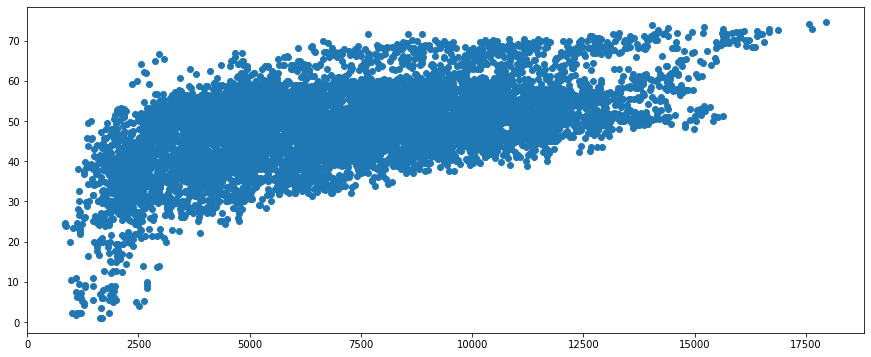

In [45]:
# lets see the relation between thermal energy and price

plt.figure(figsize=(15, 6))
plt.scatter(energy["fossil"], energy["spot_price"])
plt.show()

It looks like there is a direct relation between the amount of energy produced by thermal sources and price

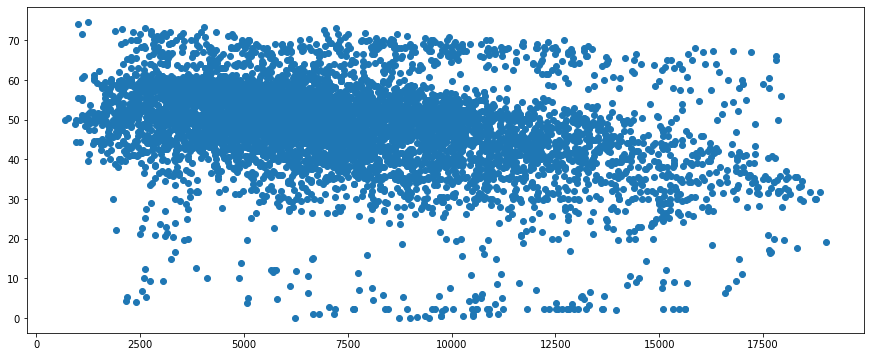

In [46]:
# relation of green energy and price

energy["green"] = energy["wind"] + energy["solar"]

plt.figure(figsize=(15, 6))
plt.scatter(energy["green"], energy["spot_price"])
plt.show()

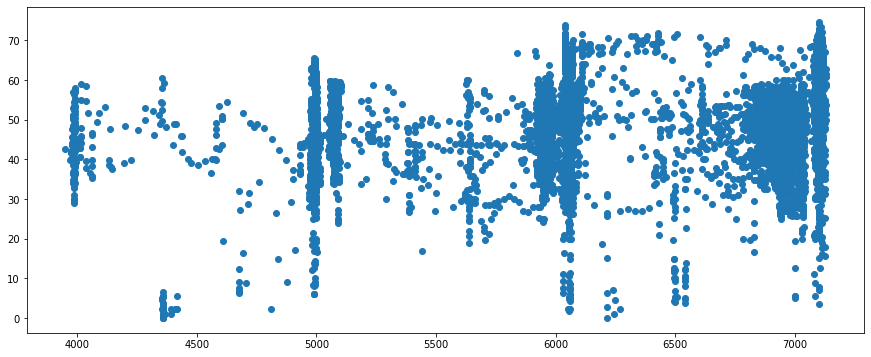

In [44]:
# nuclear vs price

plt.figure(figsize=(15, 6))
plt.scatter(energy["nuclear"], energy["spot_price"])
plt.show()

# nuclear power plants, least amount of nuclear power production, unavailability

In [47]:
# lets create a new categorical variable describing how many nuclear power plants are working every day
# we can see 4 main clusters

energy["nuclear_pp"] = pd.cut(
    energy["nuclear"],
    bins=4,
    labels=[4, 5, 6, 7]
)

energy.sample(5)

datetime  power_demand  nuclear      gas  solar   hydro  \
6895 2019-10-15 06:00:00+00:00       29718.4   5953.0  10078.2  144.8  1369.4   
3747 2019-06-06 02:00:00+00:00       23043.3   5214.2   7046.3    NaN  2273.6   
8612 2019-12-25 19:00:00+00:00       24745.8   6490.5   1869.8    2.4  8025.2   
4102 2019-06-20 21:00:00+00:00       27333.3   6998.8   7005.2    0.4  1642.5   
1206 2019-02-20 05:00:00+00:00       27678.1   7114.5   4647.7    0.2  2609.5   

        coal    wind  spot_price  year  ... green_covered_demand  \
6895  1225.0  8850.2       52.19  2019  ...             0.302674   
3747   697.0  2745.4       46.39  2019  ...                  NaN   
8612     NaN  6361.8       29.61  2019  ...             0.257183   
4102   470.0  5607.1       44.51  2019  ...             0.205153   
1206  4606.8  2403.1       56.66  2019  ...             0.086830   

      nuclear_covered_demand  gas_covered_demand  solar_covered_demand  \
6895                0.200314            0.339123              0.004872   
3747                0.226278            0.305785                   NaN   
8612                0.262287            0.075560              0.000097   
4102                0.256054            0.256288              0.000015   
1206                0.257044            0.167920              0.000007   

      hydro_covered_demand  coal_covered_demand  wind_covered_demand   fossil  \
6895              0.046079             0.041220             0.297802  11303.2   
3747              0.098666             0.030247             0.119141   7743.3   
8612              0.324306                  NaN             0.257086      NaN   
4102              0.060092             0.017195             0.205138   7475.2   
1206              0.094280             0.166442             0.086823   9254.5   

       green  nuclear_pp  
6895  8995.0           6  
3747     NaN           5  
8612  6364.2           7  
4102  5607.5           7  
1206  2403.3           7  

[5 rows x 26 columns]

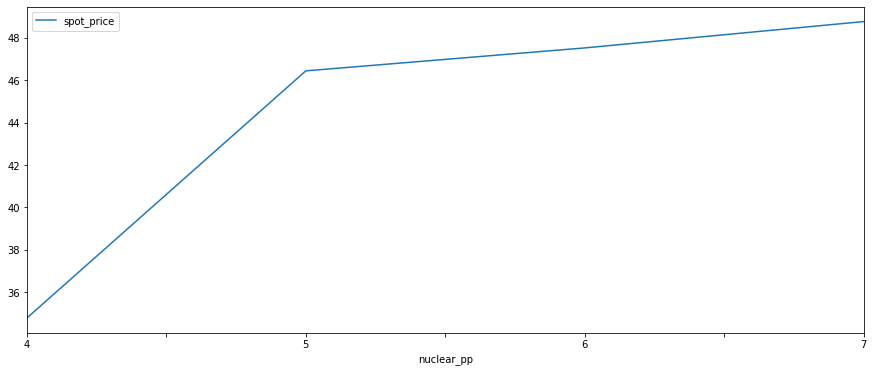

In [48]:
# relation between nuclear power and price

energy.groupby("nuclear_pp").mean()\
[["spot_price"]].plot(figsize=(15, 6))

Causality vs correlation

Did price go up when more nuclear power plant were working? 

Did nuclear power plants decide to go on maintenance tasks when prices where lower? 